In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,log_loss, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Data transformation 
file_path = "data/voice.csv"
data = pd.read_csv(file_path)
data['label'] = data['label'].map({'male': 1, 'female': 0})

X = data.drop(columns=['label']).values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

In [3]:
# the function of the neural network and the batch normalization
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_safe(z):
    return np.clip(sigmoid(z), 1e-7, 1 - 1e-7)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def batch_norm_forward(Z, gamma, beta, eps=1e-5):
    mu = np.mean(Z, axis=1, keepdims=True)
    var = np.var(Z, axis=1, keepdims=True)
    Z_norm = (Z - mu) / np.sqrt(var + eps)
    out = gamma * Z_norm + beta
    cache = (Z, Z_norm, mu, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    Z, Z_norm, mu, var, gamma, beta, eps = cache
    m = Z.shape[1]

    dZ_norm = dout * gamma
    dvar = np.sum(dZ_norm * (Z - mu) * -0.5 * (var + eps)**(-1.5), axis=1, keepdims=True)
    dmu = np.sum(dZ_norm * -1 / np.sqrt(var + eps), axis=1, keepdims=True) + dvar * np.sum(-2 * (Z - mu), axis=1, keepdims=True) / m

    dZ = dZ_norm / np.sqrt(var + eps) + dvar * 2 * (Z - mu) / m + dmu / m
    dgamma = np.sum(dout * Z_norm, axis=1, keepdims=True)
    dbeta = np.sum(dout, axis=1, keepdims=True)

    return dZ, dgamma, dbeta

def initialize_parameters(layers):
    parameters = {}
    np.random.seed(42)

    for l in range(1, len(layers)):
        parameters[f'W{l}'] = np.random.randn(layers[l], layers[l-1]) * 0.01
        parameters[f'b{l}'] = np.zeros((layers[l], 1))
        parameters[f'gamma{l}'] = np.ones((layers[l], 1))
        parameters[f'beta{l}'] = np.zeros((layers[l], 1))

    return parameters

def forward_propagation(X, parameters, layers, use_batch_norm=True):
    caches = []
    A = X

    for l in range(1, len(layers)):
        Z = parameters[f'W{l}'].dot(A) + parameters[f'b{l}']
        if use_batch_norm:
            A, cache_bn = batch_norm_forward(Z, parameters[f'gamma{l}'], parameters[f'beta{l}'])
        else:
            A = Z
        A = relu(A) if l < len(layers) - 1 else sigmoid_safe(A)
        caches.append((A, cache_bn) if use_batch_norm else (A, None))

    return A, caches

def back_propagation(X, y, parameters, caches, layers, use_batch_norm=True):
    gradients = {}
    m = y.shape[1]
    A_prev, _ = caches[-1]
    dA = A_prev - y

    for l in reversed(range(1, len(layers))):
        A_prev, cache_bn = caches[l-1]
        dA_relu = dA * (relu_derivative(A_prev) if l < len(layers) - 1 else 1)

        if use_batch_norm:
            dZ, dgamma, dbeta = batch_norm_backward(dA_relu, cache_bn)
            gradients[f'dgamma{l}'] = dgamma
            gradients[f'dbeta{l}'] = dbeta
        else:
            dZ = dA_relu

        gradients[f'dW{l}'] = 1 / m * dZ.dot(caches[l-2][0].T if l > 1 else X.T)
        gradients[f'db{l}'] = 1 / m * np.sum(dZ, axis=1, keepdims=True)

        if l > 1:
            dA = parameters[f'W{l}'].T.dot(dZ)

    return gradients

def update_parameters(parameters, gradients, learning_rate):
    for key in parameters.keys():
        if key in gradients:
            parameters[key] -= learning_rate * gradients[f'd{key}']

    return parameters

def predict(X, parameters, layers, use_batch_norm=True):
    A, _ = forward_propagation(X, parameters, layers, use_batch_norm)
    return (A >= 0.5).astype(int)

def mini_batch_generator(X, y, batch_size):
    m = X.shape[1]
    permutation = np.random.permutation(m)
    X_shuffled = X[:, permutation]
    y_shuffled = y[:, permutation]

    for i in range(0, m, batch_size):
        X_batch = X_shuffled[:, i:i+batch_size]
        y_batch = y_shuffled[:, i:i+batch_size]
        yield X_batch, y_batch

def neural_network(X, y, layers, learning_rate=0.1, epochs=10, batch_size=32, use_batch_norm=True):
    parameters = initialize_parameters(layers)
    train_loss = []
    train_acc = []

    for epoch in range(epochs):
        epoch_loss = []
        epoch_acc = []

        for X_batch, y_batch in mini_batch_generator(X, y, batch_size):
            A, caches = forward_propagation(X_batch, parameters, layers, use_batch_norm)

            epoch_loss.append(log_loss(y_batch.flatten(), A.flatten()))
            y_pred = (A >= 0.5).astype(int)
            epoch_acc.append(accuracy_score(y_batch.flatten(), y_pred.flatten()))

            gradients = back_propagation(X_batch, y_batch, parameters, caches, layers, use_batch_norm)
            parameters = update_parameters(parameters, gradients, learning_rate)

        train_loss.append(np.mean(epoch_loss))
        train_acc.append(np.mean(epoch_acc))

        print(f"Epoch {epoch+1}/{epochs} (BatchNorm={'On' if use_batch_norm else 'Off'}): Loss = {train_loss[-1]:.4f}, Accuracy = {train_acc[-1]:.4f}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.legend()
    plt.show()

    return parameters

In [4]:
# Data preparation
X = X_train.T
y = y_train.reshape((1, y_train.shape[0]))

Epoch 1/30 (BatchNorm=On): Loss = 0.9249, Accuracy = 0.3742
Epoch 2/30 (BatchNorm=On): Loss = 0.9227, Accuracy = 0.3773
Epoch 3/30 (BatchNorm=On): Loss = 0.9241, Accuracy = 0.3785
Epoch 4/30 (BatchNorm=On): Loss = 0.9302, Accuracy = 0.3795
Epoch 5/30 (BatchNorm=On): Loss = 0.9216, Accuracy = 0.3816
Epoch 6/30 (BatchNorm=On): Loss = 0.9262, Accuracy = 0.3738
Epoch 7/30 (BatchNorm=On): Loss = 0.9223, Accuracy = 0.3809
Epoch 8/30 (BatchNorm=On): Loss = 0.9274, Accuracy = 0.3721
Epoch 9/30 (BatchNorm=On): Loss = 0.9246, Accuracy = 0.3756
Epoch 10/30 (BatchNorm=On): Loss = 0.9296, Accuracy = 0.3750
Epoch 11/30 (BatchNorm=On): Loss = 0.9283, Accuracy = 0.3687
Epoch 12/30 (BatchNorm=On): Loss = 0.9249, Accuracy = 0.3787
Epoch 13/30 (BatchNorm=On): Loss = 0.9232, Accuracy = 0.3697
Epoch 14/30 (BatchNorm=On): Loss = 0.9252, Accuracy = 0.3793
Epoch 15/30 (BatchNorm=On): Loss = 0.9290, Accuracy = 0.3686
Epoch 16/30 (BatchNorm=On): Loss = 0.9220, Accuracy = 0.3778
Epoch 17/30 (BatchNorm=On): Loss 

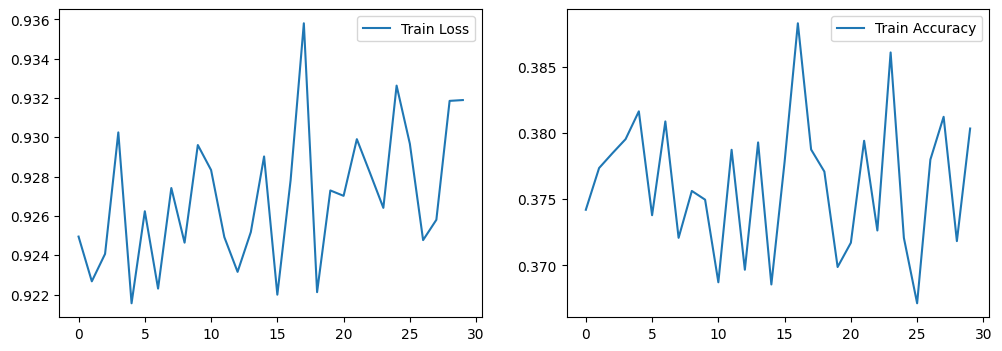

Epoch 1/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4637
Epoch 2/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4640
Epoch 3/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4629
Epoch 4/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4618
Epoch 5/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4626
Epoch 6/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4634
Epoch 7/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4637
Epoch 8/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4632
Epoch 9/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4626
Epoch 10/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4618
Epoch 11/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4616
Epoch 12/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4634
Epoch 13/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4613
Epoch 14/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4613
Epoch 15/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4618
Epoch 16/30 (BatchNorm=Off): Loss = 0.6931, Accuracy = 0.4613
Epoch 17/30 (Batc

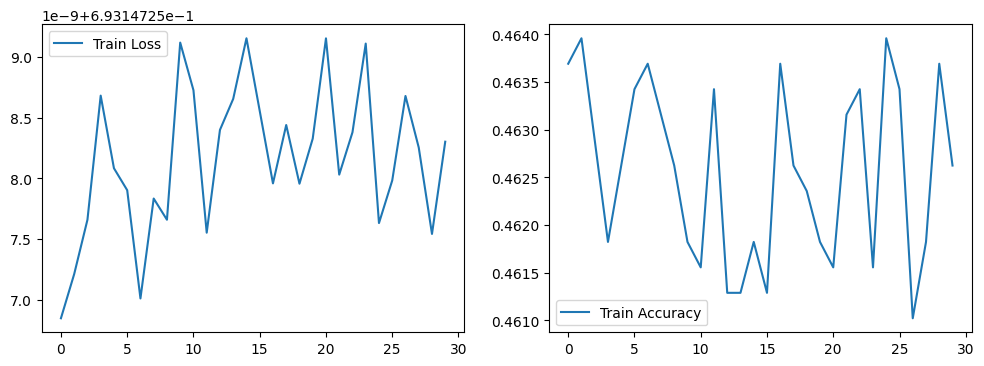

Performance (BatchNorm=On):
Accuracy: 0.4353
Precision: 0.4703
Recall: 0.4926
F1 Score: 0.4812


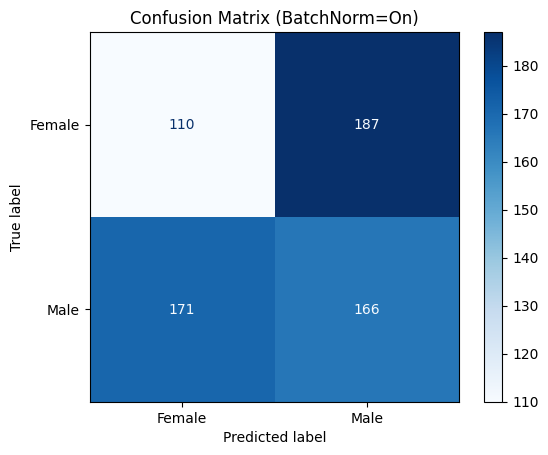

Performance (BatchNorm=Off):
Accuracy: 0.4748
Precision: 0.8333
Recall: 0.0148
F1 Score: 0.0292


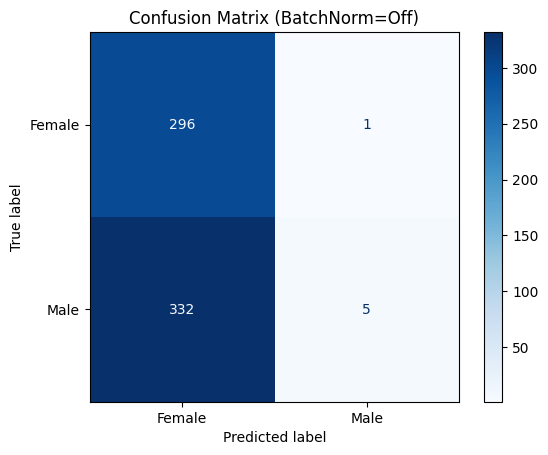

In [5]:
layers = [X.shape[0], 32, 16, 8, 1]  # Example with 3 hidden layers

# NX with BN
parameters_bn = neural_network(X, y, layers, learning_rate=0.01, epochs=30, batch_size=64, use_batch_norm=True)

# NN without BN
parameters_no_bn = neural_network(X, y, layers, learning_rate=0.01, epochs=30, batch_size=64, use_batch_norm=False)

X_test = X_test.T
y_test = y_test.reshape((1, y_test.shape[0]))

# Prediction and performance
for use_bn, params in zip([True, False], [parameters_bn, parameters_no_bn]):
    y_test_pred = predict(X_test, params, layers, use_batch_norm=use_bn)

    accuracy = accuracy_score(y_test.flatten(), y_test_pred.flatten())
    precision = precision_score(y_test.flatten(), y_test_pred.flatten())
    recall = recall_score(y_test.flatten(), y_test_pred.flatten())
    f1 = f1_score(y_test.flatten(), y_test_pred.flatten())

    print(f"Performance (BatchNorm={'On' if use_bn else 'Off'}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test.flatten(), y_test_pred.flatten())
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
    cm_display.plot(cmap='Blues')
    plt.title(f"Confusion Matrix (BatchNorm={'On' if use_bn else 'Off'})")
    plt.show()
